In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [13]:
# ------------------------------------------
# Настраиваемые параметры (может менять пользователь)
# ------------------------------------------
ONE_CYLINDRE_COST_USD = 13000  # цена одного вала в долларах
AMORT_COST_PER_METER = 0.18  # амортизация и издержки в USD за один метр прогона
AMORT_YEARS = 5  # период амортизации валов (в годах)
N_vals = 7  # количество валов

# Машины и связанные с ними параметры
machines = {
    'MarkAndy': {
        'CYLINDRE_WIDTH': 250,  # ширина вала в мм для MarkAndy
        'TECH_LOSS': 72  # тех. потери для MarkAndy
    },
    'Weigang': {
        'CYLINDRE_WIDTH': 450,  # ширина вала в мм для Weigang
        'TECH_LOSS': 15.6  # тех. потери для Weigang
    }
}

# ------------------------------------------
# Фиксированные параметры
# ------------------------------------------
ONE_ZUB_mm = 3.175  # шаг изменения длины окружности вала (мм)
M_range = range(76, 190)  # Диапазон значений для M (доступные размеры валов)
SLED_SIZE_mm = 7.5  # ширина "лыж"
MAX_KNIFES_ON_ROLL = 10  # максимальное количество ножей на станке

# Параметры джамбороля и роликов
MAX_JAMBO_ROLL_WIDTH_m = 1.53  # Максимальная ширина джамбороля (м)
JAMBO_ROLL_LENGTH_m = 6000  # Длина джамбороля (м)
MIN_ROLLIC_LENGTH_m = 100  # минимальная длина ролика (м)
MAX_ROLLIC_LENGTH_m = 2000  # максимальная длина ролика (м)

# Стоимость материалов
material_costs = {
    'пленка': 0.63,
    'полуглянец': 0.44,
    'термочек': 0.56
}

# Параметры для 'mer' (межэтикеточное расстояние)
mer_values = {
    'пленка': 3,
    'термочек': 3,
    'default': 5
}


def params(selected_machine, CYLINDRE_WIDTH, TECH_LOSS):
    """
    Функция выводит все важные параметры системы,
    сгруппированные по логическим блокам.
    """

    print("==========================================")
    print("             СТОИМОСТЬ И АМОРТИЗАЦИЯ       ")
    print("==========================================")
    print(f"{'Стоимость материалов (USD/м²):':35}")
    for mat, cost in material_costs.items():
        print(f"{'':5}{mat}: {cost}")
    print(f"{'Цена одного вала (USD):':35}{ONE_CYLINDRE_COST_USD}")
    print(f"{'Амортизация (USD/м):':35}{AMORT_COST_PER_METER}")
    print(f"{'Период амортизации (лет):':35}{AMORT_YEARS}")

    print("\n==========================================")
    print("            ПАРАМЕТРЫ МАШИН И ВАЛОВ        ")
    print("==========================================")
    print(f"{'Выбранная машина:':35}{selected_machine}")
    print(f"{'Ширина вала (мм):':35}{CYLINDRE_WIDTH}")
    print(f"{'Шаг изменения длины вала (мм/зуб):':35}{ONE_ZUB_mm}")
    print(f"{'Диапазон размеров вала (M_range):':35}{M_range.start}-{M_range.stop}")
    print(f"{'Кол-во валов (N_vals):':35}{N_vals}")
    print(f"{'Мин. длина ролика (м):':35}{MIN_ROLLIC_LENGTH_m}")
    print(f"{'Макс. длина ролика (м):':35}{MAX_ROLLIC_LENGTH_m}")

    print("\n==========================================")
    print("        МАТЕРИАЛЫ И ТЕХНИЧЕСКИЕ ПОТЕРИ     ")
    print("==========================================")
    print(f"{'Тех. потери бумаги (м):':35}{TECH_LOSS}")
    print(f"{'Ширина лыж (SLED_SIZE_mm):':35}{SLED_SIZE_mm}")
    print(f"{'Межэтикеточное расстояние (mer_values, мм):':35}")
    for mat, distance in mer_values.items():
        print(f"{'':5}{mat}: {distance}")

    print("\n==========================================")
    print("        ПАРАМЕТРЫ ДЖАМБОРОЛЯ И РОЛИКОВ     ")
    print("==========================================")
    print(f"{'Макс. ширина джамбороля (м):':35}{MAX_JAMBO_ROLL_WIDTH_m}")
    print(f"{'Длина джамбороля (м):':35}{JAMBO_ROLL_LENGTH_m}")
    print(f"{'Макс. кол-во ножей на станке:':35}{MAX_KNIFES_ON_ROLL}")
    print("==========================================")

In [14]:
def fn(M, s1n, mer):
    """
    Вычисления в миллиметрах!

    Функция определяет количество этикеток шириной `s1n` и межручьевое расстояние `mer`,
    которые могут уместиться на валу, длина окружности которого определяется
    как M * ONE_ZUB_mm (где M - количество зубьев вала).

    Параметры:
    M    : int  - количество зубьев на валу (определяет длину окружности вала)
    s1n  : int  - ширина этикетки в миллиметрах
    mer  : int  - межэтикеточное расстояние (МЭР) в миллиметрах

    Возвращает:
    int  - количество этикеток, которые могут уместиться на валу
    """
    i = 0
    while (i * (s1n + mer)) <= ONE_ZUB_mm * M:
        i += 1
    return i - 1

In [15]:
def fm(s2n, mer, roll_width=None):
    """
    Вычисления в миллиметрах!
    Ф-ция определяет кол-во этикеток шириной = s2n и МЭР=mer,
    которые уместятся на валу шириной roll_width.

    Параметры:
    s2n : int  - ширина этикетки в миллиметрах
    mer : int  - межручьевое расстояние (МЭР) в миллиметрах
    roll_width : int или None
        Ширина вала в миллиметрах. Если None, берётся текущее значение CYLINDRE_WIDTH.
    """

    if roll_width is None:
        roll_width = CYLINDRE_WIDTH

    i = 0
    while (i * (s2n + mer) - mer) + SLED_SIZE_mm * 2 <= roll_width:
        i += 1
    return i - 1

<dt>Определим формулу потерь Loss_i для i-того заказа</dt>
<dd> - потери выражаются в долларах </dd>
<dd> - миллиметры приводим в метры </dd>

$$
Loss_i = S_i * price_i = n_i * h_i * L_i * price_i =
\overbrace{
[\underbrace{\frac{RUT  * 10^{3}}{fm}}_\text{кол-во этикеток в одном ручье}
* lsh}
^\text{высота всех отступов в ручье}
 *
\underbrace{(lsv * (fm-1) + 2 ssd)}_\text{ширина всех отступов в ряду}
* price * 10^{-6} ]_i
$$

<dt>Где</dt>
<dd>- lsh (дано) - lable spacing h</dd>
<dd>- lsv (дано) - lable spacing v</dd>
<dd>- ssd (дано) - SLED_SIZE_mm</dd>
<dd>- RUT (дано) - Report_Unit_Thousands</dd>
<dd>- fm (вычисляем) - Ф-ция определяет кол-во этикеток шириной = S2n и МЭР=mer,
    которые уместятся на валу шириной roll_width.</dd>
<dd>- price (вычисляем) - цена кв. метра марериала</dd>

In [16]:
def Loss_i(lsh, lsv, RUT, price, s2n, mer=None):
    this_fm = fm(s2n, mer) if mer else fm(s2n, lsv)  #roll_width
    return (lsh * RUT * (lsv * (this_fm - 1) + 2 * SLED_SIZE_mm) * price) / (this_fm * 1000)

<dt> Уточним формулу потерь Loss_i для i-того заказа с учетом тех. потерь</dt>

$$
LossTL_i =  \underbrace{TL}_\textrm{длина пробега тех.потерь}*
\underbrace{[fm * (S_2 + lsv)  - lsv + 2 ssd)] * price * 10^-3}_\textrm{ширина печати}$$

<dt>Где</dt>
<dd>- ssd (дано) - SLED_SIZE_mm</dd>
<dd>- lsv (дано) - lable spacing v</dd>
<dd>- TL (дано) TECH_LOSS = 60  # 15.6 технические потери бумаги метры пробега</dd>
<dd>- fm (вычисляем) - Ф-ция определяет кол-во этикеток шириной = S2n и МЭР=mer,
    которые уместятся на валу шириной roll_width.</dd>
<dd>- S_2 (дано) - ширина этикетки</dd>

In [17]:
def LossTL_i(lsv, price, s2n, mer=None):
    this_fm = fm(s2n, mer) if mer else fm(s2n, lsv)  #roll_width
    this_cylinder_width = (this_fm * (s2n + lsv) - lsv + 2 * SLED_SIZE_mm) * price / 1000
    assert this_cylinder_width <= CYLINDRE_WIDTH
    return TECH_LOSS * this_cylinder_width  # переводим миллиметры в метры

In [18]:
def SummLoss_i(lsh, lsv, RUT, price, s2n, mer=None):
    li = Loss_i(lsh, lsv, RUT, price, s2n, mer)
    tli = LossTL_i(lsv, price, s2n, mer)
    return li + tli

$$
LossOpt(M_i) = SummLoss_i - LossTL_i(TL) - LossOpt(M_i)
$$

<dt> Теперь будем оптимизировать номер вала M</dt>
<dd> при этом lsh - отступ поперек вала станет переменным</dd>


$$
lsh = f(M) = M * oz -  fn(M) * (S_1 + mer)
$$

<dt>Где</dt>
<dd>- oz (дано) - ONE_ZUB_mm</dd>
<dd>- S_1 (дано) - высота этикетки</dd>
<dd>- fn (выч. целое) - Функция определяет количество этикеток шириной `s1n` и межручьевое расстояние `mer`,
    которые могут уместиться на валу, длина окружности которого определяется
    как M * ONE_ZUB_mm (где M - количество зубьев вала).</dd>


In [20]:
def lsh(s1n, mer, M):
    return M * ONE_ZUB_mm - fn(M, s1n, mer) * (s1n + mer)

<dd> С учетом фармулы для lsh уточним расчет LossOpt_i</dd>

In [21]:
def LossOpt_i(M, lsv, RUT, price, s1n, s2n, mer):
    this_lsh = lsh(s1n, mer, M)
    Loss_i_mer = Loss_i(lsh=mer, lsv=mer, RUT=RUT, price=price, s2n=s2n)
    Loss_i_real = Loss_i(lsh=this_lsh, lsv=lsv, RUT=RUT, price=price, s2n=s2n)
    return Loss_i_real - Loss_i_mer

In [22]:
def load_and_process_data(file_path: str, mer_values: dict) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], List[str]]:
    """
    Загружает данные из файла Excel, обрабатывает их,
    добавляет колонку 'mer' в зависимости от 'Material',
    фильтрует данные и возвращает кортеж из:
    - DataFrame (idf) после обработки,
    - DataFrame (available_periods_df) с доступными периодами,
    - список строк (available_months),
    - список строк (expected_columns).
    """
    idf = pd.read_excel(file_path, engine='openpyxl')
    idf['mer'] = idf['Material'].apply(lambda x: mer_values.get(x, mer_values['default']))
    idf = idf[idf['Report_Unit_Thousands'] > 0]
    idf.reset_index(drop=True, inplace=True)

    expected_columns = [
        'Month', 'SKU', 'Product', 'Report_Unit_Thousands', 'Km',
        'L dimension (mm)', 'Cylinder number', 'label spacing v',
        'label spacing h', 'Gross_Sales', 'Type_of_Label', 'Size1', 'Size2',
        'Material', 'Embossing', 'Color', 'Glue_Type', 'mer'
    ]

    required_cols = ['Size2', 'Size1', 'Report_Unit_Thousands', 'label spacing h', 'label spacing v', 'Material']
    idf = idf[idf[required_cols].notna().all(axis=1)]

    available_months = sorted(set(idf['Month']))
    available_periods_df = pd.DataFrame(available_months, columns=['Available_Periods'])

    return idf, available_periods_df, available_months, expected_columns

In [23]:
def adjust_data(idf: pd.DataFrame, expected_columns: list) -> Tuple[pd.DataFrame, int, int]:
    """
    Обрабатывает DataFrame, нормализуя данные по колонке 'L dimension (mm)'.

    Для строк, где 'L dimension (mm)' соответствует 'Size2', значения колонок 'Size1' и 'Size2'
    меняются местами. Новая колонка 'reverse' отмечает:
    - 0: если 'L dimension (mm)' соответствует 'Size1'.
    - 1: если 'L dimension (mm)' соответствует 'Size2'.
    - -1: если не соответствует ни одному из них.

    После обработки данные объединяются, и DataFrame приводится к ожидаемым колонкам.

    Параметры:
    ----------
    idf : pd.DataFrame
        Исходный DataFrame для обработки.
    expected_columns : list
        Список колонок, к которым нужно привести итоговый DataFrame.

    Возвращает:
    -----------
    Tuple[pd.DataFrame, int, int]
        - Обработанный DataFrame, приведённый к колонкам expected_columns.
        - Количество строк, где 'L dimension (mm)' соответствует 'Size2' (перевернутых строк).
        - Общее количество строк в обработанном DataFrame.
    """
    res = []
    for _, row in idf.iterrows():
        l = row['L dimension (mm)']
        s1 = row['Size1']
        s2 = row['Size2']
        if l == s1:
            res.append(0)
        elif l == s2:
            res.append(1)
        else:
            res.append(-1)

    idf['reverse'] = pd.Series(res)
    idf_rev = idf[idf['reverse'] == 1].copy()
    idf_nrev = idf[idf['reverse'] == 0].copy()

    # Считаем количество перевёрнутых строк
    reversed_count = len(idf_rev)

    idf_rev.columns = [
        'Month', 'SKU', 'Product', 'Report_Unit_Thousands', 'Km',
        'L dimension (mm)', 'Cylinder number', 'label spacing h',
        'label spacing v', 'Gross_Sales', 'Type_of_Label', 'Size2', 'Size1',
        'Material', 'Embossing', 'Color', 'Glue_Type', 'mer', 'reverse'
    ]

    idf = pd.concat([idf_rev, idf_nrev], axis=0)
    idf = idf[expected_columns]

    # Общее количество строк после обработки
    total_count = len(idf)

    return idf, reversed_count, total_count

<dt> Ниже текущие потери БЕЗ ОПТИМИЗАЦИИ</dt>
<dd> Нужно улучшить это значение </dd>

## Множественная оптимизация валов
<dt>До этого мы выбирали один размер вала, который будет подхотьб лучше всего. А теперь будем выбирать наборы валов количеством от 1 до N_vals, так чтобы потрети были минимальны</dt>

<dt> На результат множественной оптимизации вслияет способ выбора групп заказов. Для каждой из групп выбирается оптимальный вал. Варианты выбора групп: </dt>

<dd>0. По паретто </dd>
<dd>1. Группы заказов с одинаковым Cylinder number </dd>
<dd>2. Группы заказов с одинаковым Size1 </dd>
<dd>3. Группы заказов с одинаковым Size1 и Size2 </dd>
<dd>4. Рандомно </dd>


In [42]:
def evaluate_by_group(group_name):
    loss_for_group = []

    for lg in sorted(set(idf[group_name])):
        this_group_df = idf[idf[group_name] == lg]
        res = []
        for M in M_range:
            lossm = this_group_df.apply(lambda x: LossOpt_i(mer=x['mer'], M=M
                                                            , lsv=x['label spacing v'],
                                                            RUT=x['Report_Unit_Thousands'],
                                                            price=material_costs[x['Material']],
                                                            s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()

            res.append([M, lossm])
        best_val = sorted(res, key=lambda x: x[1])[0][0]
        best_val_loss = sorted(res, key=lambda x: x[1])[0][1]
        loss_for_group.append([lg, best_val, best_val_loss, res])
    this_loss = sum([e[2] for e in loss_for_group])
    this_loss_dict = {e[0]: e[1] for e in loss_for_group}
    return this_loss, this_loss_dict

{64: 128, 79: 79, 96: 95, 101: 101, 104: 105, 110: 111, 121: 123}

<dd>2. Группы заказов с одинаковым Size1 </dd>

In [43]:
agg_idf = idf.groupby(["Size1", 'mer']).sum()['Gross_Sales'].sort_values(ascending=False)
ddf = pd.DataFrame([agg_idf, agg_idf.cumsum() / agg_idf.sum()]).T
ddf.columns = ['Gross_Sales', 'CSP']


def get_group_of_lable(s1n, mer, N=N_vals):
    csp = ddf.loc[(s1n, mer)]['CSP']
    prev_delim = 0
    for delim in list(np.arange(0, 1, 1 / N))[1:] + [1]:
        if prev_delim <= csp < delim:
            return delim
        else:
            prev_delim = delim
    return


idf['lable_group'] = idf.apply(lambda x: get_group_of_lable(s1n=x['Size1'],
                                                            mer=x['mer'], N=N_vals) or 1, axis=1)
ddf.head()

,,Gross_Sales,CSP
Size1,mer,,
100.0,3,6150176.84,0.132616
80.0,3,3089739.78,0.199240
70.0,3,2693017.09,0.257310
200.0,3,2670609.42,0.314896
99.0,3,2120212.70,0.360614


In [44]:
this_loss, this_loss_dict = evaluate_by_group('lable_group')
idf['rec_cyl_s1g'] = idf['lable_group'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

2768


<dd>3. Группы заказов с одинаковым Size1 и Size2 </dd>

In [45]:
agg_idf = idf.groupby(["Size1", 'mer', 'Size2']).sum()['Gross_Sales'].sort_values(ascending=False)
ddf = pd.DataFrame([agg_idf, agg_idf.cumsum() / agg_idf.sum()]).T
ddf.columns = ['Gross_Sales', 'CSP']
ddf.head()


def get_group_of_lable(s1n, s2n, mer, N=N_vals):
    csp = ddf.loc[(s1n, mer, s2n)]['CSP']
    prev_delim = 0
    for delim in list(np.arange(0, 1, 1 / N))[1:] + [1]:
        if prev_delim <= csp < delim:
            return delim
        else:
            prev_delim = delim
    return


idf['lable_group_s12'] = idf.apply(lambda x: get_group_of_lable(s1n=x['Size1'], s2n=x['Size2'],
                                                                mer=x['mer'], N=N_vals) or 1, axis=1)

In [46]:
this_loss, this_loss_dict = evaluate_by_group('lable_group_s12')
idf['rec_cyl_s12g'] = idf['lable_group_s12'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

3650


<dd>1. Группы заказов с одинаковым Cylinder number </dd>

In [47]:
this_loss, this_loss_dict = evaluate_by_group('Cylinder number')
idf['rec_cyl_cylg'] = idf['Cylinder number'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

2182


In [48]:
print("Рекомендуемый набор валов: ", sorted(set(idf['rec_cyl_cylg'])))
print("потери: ", (int(this_loss)))

Рекомендуемый набор валов:  [79, 95, 101, 105, 111, 123, 128]
потери:  2182


In [49]:
print("Текущий набор валов: ", sorted(set(idf['Cylinder number'])))
print("Текущие потери: ")
print(int(idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=x['Cylinder number']
                                        , lsv=x['label spacing v'],
                                        RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                                        s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()), '$')

Текущий набор валов:  [64, 79, 96, 101, 104, 110, 121]
Текущие потери: 
2209 $


In [52]:
this_loss, this_loss_dict = evaluate_by_group('Cylinder number')
print("Содержимое словаря this_loss_dict:\n", this_loss_dict)


Содержимое словаря this_loss_dict:
 {64: 128, 79: 79, 96: 95, 101: 101, 104: 105, 110: 111, 121: 123}


<dd>4. Рандомно </dd>

In [75]:
idf['lable_group_rand'] = idf.apply(lambda x: np.random.randint(N_vals), axis=1)

In [76]:
this_loss, this_loss_dict = evaluate_by_group('lable_group_rand')
idf['rec_cyl_rand'] = idf['lable_group_rand'].apply(lambda x: this_loss_dict[x])

print(int(this_loss))

37379


# Оптимизация количества ручьев

In [52]:
idf[['Report_Unit_Thousands', 'Km', 'L dimension (mm)', 'Cylinder number',
     'label spacing v', 'Size1', 'Size2', 'mer']].head()

,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,Size1,Size2,mer
0,17.350,0.927,100.0,101,6.892,100.0,90.0,5
1,423.885,9.062,60.0,101,4.135,60.0,58.0,3
2,7.570,0.950,225.0,79,25.825,225.0,55.0,3
3,33.380,1.696,95.0,96,6.600,95.0,58.0,3
4,15.700,0.798,95.0,96,6.600,95.0,58.0,3


In [53]:
def get_range_of_k(lable_width, mer):
    """
    Функция определяет допустимое кол-во ручьев на валу шириной CYLINDRE_WIDTH
    в зависимости от ширины этикетки lable_width и МЭР mer
    Все измерения в метрах!
    """
    good_ks = []
    k = 1
    while k * (
            lable_width + mer) - mer + 2 * SLED_SIZE_mm * 0.001 < CYLINDRE_WIDTH:  # 12.04 было k * (lable_width + mer) + mer
        good_ks.append(k)
        k += 1
    return good_ks


assert get_range_of_k(0.095, 0.003) == [1, 2, 3, 4]

In [54]:
def Loss_4K(lable_hights, lable_width, mer, pcs, this_k, material):
    """
    Функция считае потери в рублях за печать pcs штук этикеток
    размером hights на width в this_k ручья
    material_costs
    AMORT_COST_PER_METER
    TECH_LOSS
    """
    this_loss = (AMORT_COST_PER_METER * (lable_hights + mer) * pcs) / this_k + \
                ((lable_width + mer) * this_k - mer + 2 * SLED_SIZE_mm * 0.001) * \
                material_costs[material] * TECH_LOSS  # Цена метра квадратного бумаги в долларах
    return this_loss

In [55]:
res = []
for _, row in idf.iterrows():
    lable_hights = row.Size1 / 1000  # длина
    lable_width = row.Size2 / 1000  # ширина
    this_material = row['Material']
    mer = row.mer / 1000
    pcs = row['Report_Unit_Thousands'] * 1000
    ks = get_range_of_k(lable_width, mer)
    losses = []
    for k in ks:
        this_loss = Loss_4K(lable_hights, lable_width, mer, pcs, k, this_material)
        losses.append([k, this_loss])

    if losses:
        k_optim = sorted(losses, key=lambda x: int(x[1]))[0][0]
        k_max = max([e[0] for e in losses])
        res.append([k_optim, k_max])
    else:
        res.append([0, 0])

idf.reset_index(drop=True, inplace=True)
idf['k_optim'] = pd.Series([e[0] for e in res])
idf['k_max'] = pd.Series([e[1] for e in res])

In [56]:
idf[['Report_Unit_Thousands', 'Km', 'L dimension (mm)', 'Cylinder number',
     'label spacing v', 'Size1', 'Size2', 'mer', 'k_optim', 'k_max']][idf.k_optim != idf.k_max]

,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,Size1,Size2,mer,k_optim,k_max
22,4.640,0.446,180.0,121,12.088,180.0,45.0,3,7,9
23,4.490,0.431,180.0,121,12.088,180.0,45.0,3,7,9
38,7.350,0.307,80.0,79,3.608,80.0,65.0,3,5,6
58,2.760,0.421,130.0,96,22.400,130.0,60.0,3,4,6
59,7.200,0.231,60.0,101,4.135,70.0,60.0,3,5,6
...,...,...,...,...,...,...,...,...,...,...
10864,3.495,0.133,70.0,96,5.000,70.0,70.0,3,3,5
10868,2.060,0.165,76.0,101,5.000,76.0,110.0,3,2,3
10870,2.110,0.226,100.0,101,5.000,80.0,100.0,3,2,4
10871,2.330,0.249,100.0,101,5.000,80.0,100.0,3,3,4


In [57]:
(idf.k_max - idf.k_optim).sum()

2182

#  Джамбо ролли

#### Для каждого заказа выберем максимальное кол-во ручьев k_optim и соответственную ширину печати paint_width_m

In [32]:
idf.head()

,Month,SKU,Product,Report_Unit_Thousands,Km,L dimension (mm),Cylinder number,label spacing v,label spacing h,Gross_Sales,...,Material,Embossing,Color,Glue_Type,mer,lable_group,rec_cyl_s1g,rec_cyl_cylg,k_optim,k_max
0,Август 2021 г.,Этикетка 90*100 полуглянец,Пиво Белогвардейское,17.350,0.927,100.0,101,6.892,5.0,20142.48,...,полуглянец,NaN,NaN,None,5,0.714286,110,101,2,4
1,Август 2021 г.,Термочек 58*60 Termol TOP,Термочек для Даурии,423.885,9.062,60.0,101,4.135,3.0,104390.16,...,термочек,NaN,NaN,None,3,0.571429,101,101,7,7
2,Август 2021 г.,"Этикетка 55*225 пленка, белая, акр.","Ветчина К чаю (0,4) (Круглый год)",7.570,0.950,225.0,79,25.825,5.0,7334.27,...,пленка,NaN,белая,акриловый,3,1.000000,81,82,3,7
3,Август 2021 г.,"Этикетка 58*95 пленка, белая, акр.",Сосиски докторские ТМ Даурия 300 гр.,33.380,1.696,95.0,96,6.600,4.0,14086.03,...,пленка,NaN,белая,акриловый,3,0.142857,94,94,4,7
4,Август 2021 г.,"Этикетка 58*95 пленка, белая, акр., тиснение",Сосиски Баварские 300г,15.700,0.798,95.0,96,6.600,4.0,9512.94,...,пленка,тиснение,белая,акриловый,3,0.142857,94,94,3,7


In [66]:
idf['optim_cylindre'] = idf['rec_cyl_cylg']

In [67]:

idf['paint_width_mm'] = idf.apply(lambda x: ((x['Size2'] + x['mer']) * x['k_optim']) - x['mer'] + 2 * SLED_SIZE_mm,
                                  axis=1)

In [68]:
def one_roll_loss(M, this_s1, this_s2, this_mer, num_lables, this_fn=None, this_fm=None):
    """
        функия возвращает потери в рублях за прогон одного ролля 
        M - кол-во "зубцов" вала
        ---- roll_width - ширина одного роля <= 0.45
        ---- roll_length - длина одного ролля
        this_s1 - высота этикетки
        this_s2 - ширина этикетки
        this_mer - МЭР для этикетки
        num_lables - кол-во этикеток
        reverse - если True, то this_s1 и this_s2 меняются местами
        
        returns (loss_m2, loss_rub, roll_width, roll_length) 
    """
    # посчитаем длину ширину одного ПРИНТА (то, что отпечатывает один вал за один раз)
    if not this_fm:
        this_fm = fm(roll_width=450, s2n=this_s2,
                     mer=this_mer)  # кол-во этикеток, кот. поместится на роллик по ширин, вдоль вала

    print_width_m = ((this_s2 + this_mer) * this_fm - this_mer + 2 * SLED_SIZE_mm * 0.001) / 1000
    if not this_fn:
        this_fn = fn(M=M, s1n=this_s1, mer=this_mer)  # кол-во этикеток, кот. поместится на роллик по длине поперек вала
    print_higth_m = ((this_s1 + this_mer) * this_fn) / 1000  # было +  this_mer

    # посчитаем потери вдоль и поперек вала на один ПРИНТ
    val_hights_m = ONE_ZUB_mm * M / 1000
    loss_hights_m = val_hights_m - print_higth_m

    # посчитаем кол-во этикеток на одном ПРИНТЕ
    num_lables_one_print = this_fm * this_fn
    if num_lables_one_print == 0:
        num_lables_one_print = 1
        print(M, this_s1, this_s2, this_mer, num_lables)
        print(this_fn, this_fm)

    # чтобы напечатать num_lables этикеток, нужно сделать num_prints принтов
    num_prints = np.ceil(num_lables / num_lables_one_print)
    total_print_hights_m = print_higth_m * num_prints
    loss_m2 = print_width_m * loss_hights_m * num_prints

    return [loss_m2, loss_m2 * PAPER_PRICE_RUB, print_width_m, total_print_hights_m, val_hights_m, num_prints]


one_roll_loss(M=185, this_s1=70, this_s2=95, this_mer=3, num_lables=1096655, this_fm=6)

[45.10970225437522, 3247.898562315016, 0.585015, 13342.648, 0.587375, 22847.0]

In [69]:
losses_list = [one_roll_loss(M=r.optim_cylindre, this_s1=r.Size1, this_s2=r.Size2, this_mer=r.mer,
                             num_lables=r.Report_Unit_Thousands * 1000, this_fm=r.k_optim
                             ) for _, r in idf.iterrows()]
idf.reset_index(drop=True, inplace=True)
idf['loss_m2'] = [e[0] for e in losses_list]
idf['loss_rub'] = [e[1] for e in losses_list]
idf['roll_width'] = [e[2] for e in losses_list]
idf['roll_length'] = [e[3] for e in losses_list]
idf['val_hights_m'] = [e[4] for e in losses_list]
idf['num_prints'] = [e[5] for e in losses_list]

idf['order_id'] = idf.index

94 300.0 32.0 3 9390.0
0 5
94 300.0 32.0 3 16845.0
0 6
94 300.0 32.0 3 11085.0
0 5
94 300.0 32.0 3 6555.0
0 4
94 300.0 32.0 3 12975.0
0 5


## Best Fit Decreasing High
https://habr.com/ru/articles/136225/

In [70]:
assert fn(M=187, s1n=95, mer=3) == 6
idf['num_etiket_on_cylindre'] = idf.apply(lambda x: fn(x['optim_cylindre'], x['Size1'], x['mer']), axis=1)
rolls = []
for i, order in idf.iterrows():  #  итерируемся по заказам
    roll_width = order.roll_width
    roll_length = order.roll_length
    order_id = order.order_id
    optim_cylindre = order.optim_cylindre

    if roll_length > MAX_ROLLIC_LENGTH_m:
        for sub_roll in range(int(roll_length // MAX_ROLLIC_LENGTH_m)):
            rolls.append([roll_width, MAX_ROLLIC_LENGTH_m, order_id, optim_cylindre])
        rolls.append([roll_width, roll_length % MAX_ROLLIC_LENGTH_m, order_id, optim_cylindre])
    else:
        rolls.append([roll_width, roll_length, order_id, optim_cylindre])

layers = []
this_layer = {
    "lables": [],  # len() < MAX_KNIFES_ON_ROLL
    "max_hights": 0,  # <= MAX_ROLLIC_LENGTH_m
    "max_width": 0,  # <= MAX_JAMBO_ROLL_WIDTH_m
    "id": None,
}
i = 0
for _, row in pd.DataFrame(rolls, columns=[
    "roll_width", "roll_length", "order_id", "optim_cylindre"]).sort_values([
    "roll_length", "roll_width"], ascending=False).iterrows():
    roll_length = row.roll_length
    roll_width = row.roll_width
    order_id = row.order_id

    if len(this_layer['lables']) + 1 > MAX_KNIFES_ON_ROLL \
            or this_layer['max_width'] + roll_width > MAX_JAMBO_ROLL_WIDTH_m:
        this_layer['id'] = 1
        layers.append(this_layer)
        this_layer = {"lables": [], "max_hights": 0, "max_width": 0}
    this_layer['lables'].append([{"w": roll_width, "h": roll_length, "oid": order_id}])
    if roll_length > this_layer['max_hights']:
        this_layer['max_hights'] = roll_length
    this_layer['max_width'] += roll_width
    i += 1

In [71]:
layers = sorted(layers, key=lambda x: x["max_width"], reverse=True)
layers

[{'lables': [[{'w': 0.20901499999999998, 'h': 677.97, 'oid': 1707.0}],
   [{'w': 0.121015, 'h': 677.97, 'oid': 8283.0}],
   [{'w': 0.133015, 'h': 677.778, 'oid': 2368.0}],
   [{'w': 0.14501499999999998, 'h': 677.7, 'oid': 4705.0}],
   [{'w': 0.14501499999999998, 'h': 677.7, 'oid': 5825.0}],
   [{'w': 0.14301499999999998, 'h': 677.67, 'oid': 3606.0}],
   [{'w': 0.14301499999999998, 'h': 677.67, 'oid': 4583.0}],
   [{'w': 0.125015, 'h': 677.376, 'oid': 1794.0}],
   [{'w': 0.20901499999999998, 'h': 677.35, 'oid': 353.0}],
   [{'w': 0.156015, 'h': 677.188, 'oid': 10209.0}]],
  'max_hights': 677.97,
  'max_width': 1.52915,
  'id': 1},
 {'lables': [[{'w': 0.21601499999999998, 'h': 663.852, 'oid': 3075.0}],
   [{'w': 0.160015, 'h': 663.85, 'oid': 7459.0}],
   [{'w': 0.14501499999999998, 'h': 663.75, 'oid': 5359.0}],
   [{'w': 0.160015, 'h': 663.575, 'oid': 6842.0}],
   [{'w': 0.14001499999999997, 'h': 663.5600000000001, 'oid': 7166.0}],
   [{'w': 0.165015, 'h': 663.5500000000001, 'oid': 5782.

In [72]:
def get_layer_loss_rub(layer):
    this_loss_m2 = 0
    for lable in layer['lables']:
        for e in lable:
            this_loss_m2 += (layer['max_hights'] - e['h']) * e['w']
    return this_loss_m2

In [73]:
jumbo_rolls = []
this_JR = {
    "layers": [],
    "max_width": 0,
    "used_length": 0,  # <= MAX_ROLLIC_LENGTH_m
    "loss_m2": 0
}

for layer in layers:
    if this_JR['used_length'] + layer['max_hights'] > JAMBO_ROLL_LENGTH_m:
        jumbo_rolls.append(this_JR)
        this_JR = {"layers": [], "max_width": 0, "used_length": 0, 'loss_m2': 0}
    if layer['max_width'] > this_JR['max_width']:
        this_JR['max_width'] = layer['max_width']
    this_JR['layers'].append(layer)
    this_JR['used_length'] += layer['max_hights']
    this_JR['loss_m2'] += get_layer_loss_rub(layer) + \
                          ((this_JR['max_width'] - layer['max_width']) * layer['max_hights'])



In [ ]:
jumbo_rolls_df = pd.DataFrame(jumbo_rolls)

In [93]:
number_of_standart_widths = 3
chunks = []
prev_n = 0
chunk_size = jumbo_rolls_df.shape[0] // number_of_standart_widths
dfs = []
for i in range(1, number_of_standart_widths + 1):
    this_df = jumbo_rolls_df.iloc[prev_n:i * chunk_size, :]
    prev_n = i * chunk_size
    this_df['norm_width'] = this_df.max_width.max()
    this_df['plus_loss'] = ((this_df.norm_width - this_df.max_width) * this_df.used_length)
    dfs.append(this_df)
opt_width_jumbo_rolls_df = pd.concat(dfs, axis=0)
opt_width_jumbo_rolls_df.columns = ['layers', 'max_width', 'used_length', 'loss_m2',
                                    'norm_width', 'plus_loss']

/var/folders/mq/mflvfyxs2g9czqw0gcfnvpf00000gn/T/ipykernel_51537/2299641403.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['norm_width'] = this_df.max_width.max()
/var/folders/mq/mflvfyxs2g9czqw0gcfnvpf00000gn/T/ipykernel_51537/2299641403.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['plus_loss'] = ((this_df.norm_width - this_df.max_width) * this_df.used_length)
/var/folders/mq/mflvfyxs2g9czqw0gcfnvpf00000gn/T/ipykernel_51537/2299641403.py:9: SettingWithCopyWarning: 
A value is t

In [95]:
opt_width_jumbo_rolls_df['sum_loss_m2'] = opt_width_jumbo_rolls_df.loss_m2 + opt_width_jumbo_rolls_df.plus_loss
opt_width_jumbo_rolls_df

,layers,max_width,used_length,loss_m2,norm_width,plus_loss,sum_loss_m2
0,"[{'lables': [[{'w': 0.20901499999999998, 'h': ...",1.529150,5761.861,13.281430,1.529150,0.000000,13.281430
1,"[{'lables': [[{'w': 0.090015, 'h': 264.0, 'oid...",1.528150,5957.670,13.483743,1.529150,5.957670,19.441413
2,"[{'lables': [[{'w': 0.17101499999999997, 'h': ...",1.526105,5904.500,13.042091,1.529150,17.979203,31.021294
3,"[{'lables': [[{'w': 0.105015, 'h': 689.0400000...",1.524135,5496.934,8.485518,1.529150,27.567124,36.052642
4,"[{'lables': [[{'w': 0.18601499999999999, 'h': ...",1.523120,5489.963,12.515247,1.529150,33.104477,45.619724
...,...,...,...,...,...,...,...
208,"[{'lables': [[{'w': 0.078015, 'h': 441.288, 'o...",1.061150,5782.807,22.717824,1.256075,1127.213654,1149.931478
209,"[{'lables': [[{'w': 0.055015, 'h': 450.36, 'oi...",1.052150,5830.317,66.441933,1.256075,1188.947394,1255.389327
210,"[{'lables': [[{'w': 0.163015, 'h': 334.905, 'o...",1.024150,5674.469,76.463050,1.256075,1316.051223,1392.514273
211,"[{'lables': [[{'w': 0.14301499999999998, 'h': ...",0.994150,5897.531,51.977667,1.256075,1544.710807,1596.688474


In [96]:
# opt_width_jumbo_rolls_df.to_excel("jumbo31112024.xlsx")

             СТОИМОСТЬ И АМОРТИЗАЦИЯ       
Стоимость материалов (USD/м²):     
     пленка: 0.63
     полуглянец: 0.44
     термочек: 0.56
Цена одного вала (USD):            13000
Амортизация (USD/м):               0.18
Период амортизации (лет):          5

            ПАРАМЕТРЫ МАШИН И ВАЛОВ        
Выбранная машина:                  MarkAndy
Ширина вала (мм):                  250
Шаг изменения длины вала (мм/зуб): 3.175
Диапазон размеров вала (M_range):  76-190
Кол-во валов (N_vals):             7
Мин. длина ролика (м):             100
Макс. длина ролика (м):            2000

        МАТЕРИАЛЫ И ТЕХНИЧЕСКИЕ ПОТЕРИ     
Тех. потери бумаги (м):            72
Ширина лыж (SLED_SIZE_mm):         7.5
Межэтикеточное расстояние (mer_values, мм):
     пленка: 3
     термочек: 3
     default: 5

        ПАРАМЕТРЫ ДЖАМБОРОЛЯ И РОЛИКОВ     
Макс. ширина джамбороля (м):       1.53
Длина джамбороля (м):              6000
Макс. кол-во ножей на станке:      10
Все тесты пройдены успешно!

Доступные

C:\Users\Admin\AppData\Local\Temp\ipykernel_23336\3769179535.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_per_material = idf.groupby('Material').apply(



Текущие потери по материалам (в $):
  пленка: 2980 $
  полуглянец: 2321 $
  термочек: 1048 $

Общая сумма потерь: 6350 $


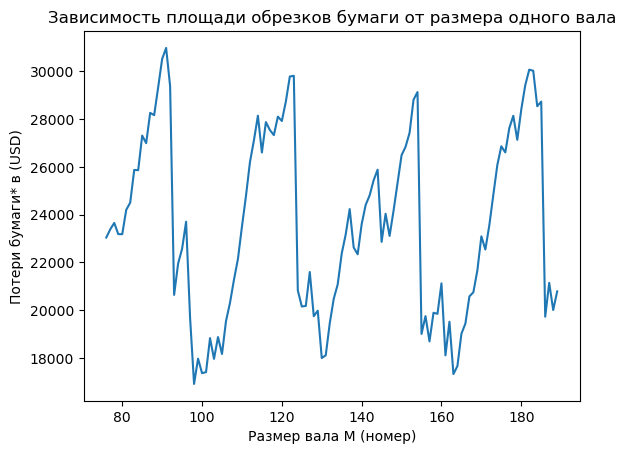

При выборе одного вала на все заказы, таким валом будет:  98
Для него потери:  16913


In [34]:
if __name__ == '__main__':
    # Выбор машины пользователем
    selected_machine = 'MarkAndy'  # Или 'Weigang'
    CYLINDRE_WIDTH = machines[selected_machine]['CYLINDRE_WIDTH']
    TECH_LOSS = machines[selected_machine]['TECH_LOSS']

    # Вывод всех актуальных параметров системы с учётом выбранной машины
    params(selected_machine, CYLINDRE_WIDTH, TECH_LOSS)

    # Тестирование функции fn
    assert fn(M=185, s1n=70, mer=3) == 8
    assert fn(M=164, s1n=100, mer=3) == 5
    assert fn(M=187, s1n=95, mer=3) == 6

    # Тестирование функции fm в зависимости от выбранной машины
    if selected_machine == 'MarkAndy':
        # Если используем MarkAndy (250 мм), результат должен быть 3
        assert fm(s2n=70, mer=3) == 3, f"Ожидалось 3, получено {fm(s2n=70, mer=3)}"
    elif selected_machine == 'Weigang':
        # Если используем Weigang (450 мм), результат должен быть 6
        assert fm(s2n=70, mer=3) == 6, f"Ожидалось 6, получено {fm(s2n=70, mer=3)}"

    print("Все тесты пройдены успешно!")

    # Загрузка данных после тестов
    idf, available_periods_df, available_months_list, expected_columns_list = load_and_process_data(
        "label_cleaned_21_24_no_customer_20240910.xlsx", mer_values
    )

    # Выводим доступные периоды
    print("\nДоступные периоды для анализа:")
    print(available_periods_df.head())  # Можно вывести .head() или весь список доступных периодов

    # Пользователь выбирает период
    period = input("Введите период (например, '2021', '2022-10' или точное значение месяца): ")

    # Фильтрация данных по выбранному периоду
    if period:
        if period.isdigit():
            # Если пользователь ввёл число, фильтруем строки, где 'Month' содержит это число
            idf = idf[idf['Month'].apply(lambda x: period in x)].reset_index(drop=True)[expected_columns_list]
        else:
            # Если пользователь ввёл точный период
            idf = idf[idf['Month'] == period].reset_index(drop=True)[expected_columns_list]

    print(f"Выбранный период: {period}")

    # Вызов функции для определения размера по направлению печати
    idf, reversed_count, total_count = adjust_data(idf, expected_columns_list)
    print(f"Все размеры в колонке Size1 это расположение по направлению печати. Перевернутых строк: {reversed_count}, всего строк: {total_count}")

    # Дополнительная статистика по выбранному периоду
    total_rows = len(idf)
    sum_report_units = idf['Report_Unit_Thousands'].sum()
    sum_km = idf['Km'].sum()
    sum_gross_sales = idf['Gross_Sales'].sum()

    unique_months = sorted(idf['Month'].unique())
    unique_cylinders = sorted(idf['Cylinder number'].unique())
    unique_materials = sorted(idf['Material'].unique())
    unique_sku_count = idf['SKU'].nunique()

    print(f"\nКоличество строк за выбранный период: {total_rows}")
    print(f"Сумма Report_Unit_Thousands: {sum_report_units}")
    print(f"Сумма Km: {sum_km}")
    print(f"Сумма Gross_Sales: {sum_gross_sales}")

    print("\nУникальные значения по Month:")
    print(unique_months)

    print("\nУникальные значения по Cylinder number:")
    print(unique_cylinders)

    print("\nУникальные значения по Material:")
    print(unique_materials)

    print(f"\nКоличество уникальных SKU: {unique_sku_count}")

    # Общая площадь = Size1 * Size2 * (Report_Unit_Thousands * 1000)
    idf['printed_area'] = idf['Size1'] * idf['Size2'] * (idf['Report_Unit_Thousands'] * 1000) / 1000000
    ### TODO Некорректное вычисление ширины печати. Нужно найти кол-во ручьев.
    # Вычисляем ширину печати
    idf['print_width'] = (idf['Report_Unit_Thousands'] * 1000 * idf['Size1']) / (idf['Km'] * 1_000_000)
    # Вычисляем площадь техпотерь на настройку
    idf['setup_loss_area'] = idf['print_width'] * (TECH_LOSS * 1000) * total_rows / 1000000
    # Вычисляем площадь лыж
    idf['sled_area'] = SLED_SIZE_mm * (idf['Km'] * 1_000_000) / 1000000
    # Вычисляем площадь управляемых потерь
    idf['loss_area'] = ((idf['label spacing h'] - idf['mer']).clip(lower=0) *
                        (idf['label spacing v'] - idf['mer']).clip(lower=0) *
                        idf['Report_Unit_Thousands'] * 1000) / 1000000
    # Общая площадь бумаги
    total_paper_area = idf['printed_area'].sum() + idf['setup_loss_area'].sum() + idf['sled_area'].sum() + idf['loss_area'].sum()
    # Доли
    printed_area_perc = (idf['printed_area'].sum() / total_paper_area) * 100
    setup_loss_area_perc = (idf['setup_loss_area'].sum() / total_paper_area) * 100
    sled_area_perc = (idf['sled_area'].sum() / total_paper_area) * 100
    loss_area_perc = (idf['loss_area'].sum() / total_paper_area) * 100

    print("Общая площадь бумаги:", total_paper_area)
    print("Суммарная площадь печати:", idf['printed_area'].sum())
    print("Суммарная ширина печати:", idf['print_width'].sum())
    print("Суммарная площадь техпотерь на настройку:", idf['setup_loss_area'].sum())
    print("Суммарная площадь 'лыж':", idf['sled_area'].sum())
    print("Суммарная площадь управляемых потерь:", idf['loss_area'].sum())
    print("Процент площади, занятой печатью, от общей площади:", printed_area_perc, "%")
    print("Процент техпотерь на настройку от общей площади:", setup_loss_area_perc, "%")
    print("Процент площади лыж от общей площади:", sled_area_perc, "%")
    print("Процент управляемых потерь от общей площади:", loss_area_perc, "%")

    # расчёт потерь в м² по материалам
    loss_per_material = (
        ((idf['label spacing h'] - idf['mer']).clip(lower=0) *
         (idf['label spacing v'] - idf['mer']).clip(lower=0) *
         idf['Report_Unit_Thousands'] * 1000) / 1000000
    ).groupby(idf['Material']).sum()

    # Рассчёт суммарных потерь в деньгах по каждому материалу.
    # Предполагается, что material_costs — это словарь вида: {Материал: цена_за_м2} или цена_за_единицу.
    # Если у вас уже есть готовая функция LossTL_i, её можно применить напрямую.
    # Для наглядности покажем прямой пересчёт через цену материала:
    loss_per_material_value = (
        ((idf['label spacing h'] - idf['mer']).clip(lower=0) *
         (idf['label spacing v'] - idf['mer']).clip(lower=0) *
         idf['Report_Unit_Thousands'] * 1000 / 1000000) *
        idf['Material'].map(material_costs)  # умножаем на цену материала
    ).groupby(idf['Material']).sum()

    # Вывод результатов
    print("Потери в м² по материалам (учтена разница между label spacing и mer):")
    print(loss_per_material)

    print("\nПотери в деньгах по материалам:")
    print(loss_per_material_value)


    #Лешины  расчеты
    # Потери в долларах без учета тех. потерь и с фактическими отступами
    idf.apply(lambda x: Loss_i(lsh=x['label spacing h'], lsv=x['label spacing v'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()
    # Потери в долларах без учета тех. потерь с отступами = mer
    idf.apply(lambda x: Loss_i(lsh=x['mer'], lsv=x['mer'],
                           RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                           s2n=x['Size2']), axis=1).sum()
    # Потери в долларах с учетом тех. потерь и с фактическими отступами
    idf.apply(lambda x: LossTL_i(lsv=x['label spacing v'],
                             price=material_costs[x['Material']],
                             s2n=x['Size2']), axis=1).sum()
    # Код возвращает общую сумму потерь в долларах (или другой единице измерения, зависящей от логики SummLoss_i) для всех строк DataFrame.
    idf.apply(lambda x: SummLoss_i(lsh=x['label spacing h'], lsv=x['label spacing v'],
                               RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                               s2n=x['Size2']), axis=1).sum()
    # Количество квадратных метров бумаги
    ((idf['Size1'] + idf['label spacing h']) * (idf['Size2'] +
                                            idf['label spacing v']) * idf[
     'Report_Unit_Thousands'] * 1000).sum() / 1000000
    # Группируем общую площадь по материалам
    area_per_material = (
        ((idf['Size1'] + idf['label spacing h']) *
         (idf['Size2'] + idf['label spacing v']) *
         idf['Report_Unit_Thousands'] * 1000) / 1000000  # Преобразование в м²
    ).groupby(idf['Material']).sum()

    # Вывод результатов
    print("Общая площадь в м² по материалам:")
    print(area_per_material)

    # Потери свыше МЭР
    ((idf['label spacing h'] - idf.mer) * (idf['label spacing v']
                                       - idf.mer) * idf['Report_Unit_Thousands'] * 1000).sum() / 1000000

    # Текущие потери
    print("Текущий набор валов: ", sorted(set(idf['Cylinder number'])))
    print("Текущие потери: ")
    print(int(idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=x['Cylinder number']
                                            , lsv=x['label spacing v'],
                                            RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                                            s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()), '$')

    # Разбивка потерь по материалам
    loss_per_material = idf.groupby('Material').apply(
        lambda group: group.apply(
            lambda x: LossOpt_i(
                mer=x['mer'],
                M=x['Cylinder number'],
                lsv=x['label spacing v'],
                RUT=x['Report_Unit_Thousands'],
                price=material_costs[x['Material']],
                s1n=x['Size1'],
                s2n=x['Size2']
            ),
            axis=1
        ).sum()
    )

    # Общая сумма потерь
    total_loss = loss_per_material.sum()

    # Вывод результатов
    print("\nТекущие потери по материалам (в $):")
    for material, loss in loss_per_material.items():
        print(f"  {material}: {int(loss)} $")

    print(f"\nОбщая сумма потерь: {int(total_loss)} $")


    # Зависимость площади обрезков бумаги от размера одного вала
    res = []
    for M in M_range:
        lossm = idf.apply(lambda x: LossOpt_i(mer=x['mer'], M=M
                                              , lsv=x['label spacing v'],
                                              RUT=x['Report_Unit_Thousands'], price=material_costs[x['Material']],
                                              s1n=x['Size1'], s2n=x['Size2']), axis=1).sum()
        res.append([M, lossm])

    plt.xlabel('Размер вала M (номер)')
    plt.ylabel('Потери бумаги* в (USD)')  # * учитывается различная стоимость бумаги, термочека и пленки
    plt.title('Зависимость площади обрезков бумаги от размера одного вала')
    plt.plot([e[0] for e in res],
             [e[1] for e in res])
    plt.show()

    best_vals = sorted(res, key=lambda x: x[1])
    best_val = best_vals[0][0]
    best_loss = best_vals[0][1]
    pd.DataFrame(best_vals[:N_vals], columns=['M', 'Loss'])

    print("При выборе одного вала на все заказы, таким валом будет: ", best_val)
    print("Для него потери: ", int(best_loss))

